In [1]:
#Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torch.nn as nn
#import plotly.graph_objects as go
from torch.autograd import Variable

In [2]:
#Data Sources
base_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/'
confirmed_cases_data_url = base_url + 'time_series_covid19_confirmed_global.csv'
death_cases_data_url = base_url + 'time_series_covid19_deaths_global.csv'
recovery_cases_data_url = base_url+ 'time_series_covid19_recovered_global.csv'
name_country = "US"

In [3]:
raw_conf_df = pd.read_csv(confirmed_cases_data_url, index_col="Country/Region")
raw_death_df = pd.read_csv(death_cases_data_url, index_col="Country/Region") 
raw_rec_df = pd.read_csv(recovery_cases_data_url, index_col="Country/Region")


In [4]:
raw_conf_df.head()

,Province/State,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,...,5/28/20,5/29/20,5/30/20,5/31/20,6/1/20,6/2/20,6/3/20,6/4/20,6/5/20,6/6/20,6/7/20,6/8/20,6/9/20,6/10/20,6/11/20,6/12/20,6/13/20,6/14/20,6/15/20,6/16/20,6/17/20,6/18/20,6/19/20,6/20/20,6/21/20,6/22/20,6/23/20,6/24/20,6/25/20,6/26/20,6/27/20,6/28/20,6/29/20,6/30/20,7/1/20,7/2/20,7/3/20,7/4/20,7/5/20,7/6/20
Country/Region,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Afghanistan,NaN,33.0000,65.0000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,...,13036,13659,14525,15205,15750,16509,17267,18054,18969,19551,20342,20917,21459,22142,22890,23546,24102,24766,25527,26310,26874,27532,27878,28424,28833,29157,29481,29640,30175,30451,30616,30967,31238,31517,31836,32022,32324,32672,32951,33190
Albania,NaN,41.1533,20.1683,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1076,1099,1122,1137,1143,1164,1184,1197,1212,1232,1246,1263,1299,1341,1385,1416,1464,1521,1590,1672,1722,1788,1838,1891,1962,1995,2047,2114,2192,2269,2330,2402,2466,2535,2580,2662,2752,2819,2893,2964
Algeria,NaN,28.0339,1.6596,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,...,8997,9134,9267,9394,9513,9626,9733,9831,9935,10050,10154,10265,10382,10484,10589,10698,10810,10919,11031,11147,11268,11385,11504,11631,11771,11920,12076,12248,12445,12685,12968,13273,13571,13907,14272,14657,15070,15500,15941,16404
Andorra,NaN,42.5063,1.5218,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,763,764,764,764,765,844,851,852,852,852,852,852,852,852,852,853,853,853,853,854,854,855,855,855,855,855,855,855,855,855,855,855,855,855,855,855,855,855,855,855
Angola,NaN,-11.2027,17.8739,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,74,81,84,86,86,86,86,86,86,88,91,92,96,113,118,130,138,140,142,148,155,166,172,176,183,186,189,197,212,212,259,267,276,284,291,315,328,346,346,346


In [5]:
raw_death_df.head()

,Province/State,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,...,5/28/20,5/29/20,5/30/20,5/31/20,6/1/20,6/2/20,6/3/20,6/4/20,6/5/20,6/6/20,6/7/20,6/8/20,6/9/20,6/10/20,6/11/20,6/12/20,6/13/20,6/14/20,6/15/20,6/16/20,6/17/20,6/18/20,6/19/20,6/20/20,6/21/20,6/22/20,6/23/20,6/24/20,6/25/20,6/26/20,6/27/20,6/28/20,6/29/20,6/30/20,7/1/20,7/2/20,7/3/20,7/4/20,7/5/20,7/6/20
Country/Region,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Afghanistan,NaN,33.0000,65.0000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,235,246,249,257,265,270,294,300,309,327,357,369,384,405,426,446,451,471,478,491,504,546,548,569,581,598,618,639,675,683,703,721,733,746,774,807,819,826,864,898
Albania,NaN,41.1533,20.1683,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,33,33,33,33,33,33,33,33,33,34,34,34,34,34,35,36,36,36,36,37,38,39,42,43,44,44,45,47,49,51,53,55,58,62,65,69,72,74,76,79
Algeria,NaN,28.0339,1.6596,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,630,638,646,653,661,667,673,681,690,698,707,715,724,732,741,751,760,767,777,788,799,811,825,837,845,852,861,869,878,885,892,897,905,912,920,928,937,946,952,959
Andorra,NaN,42.5063,1.5218,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,51,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52,52
Angola,NaN,-11.2027,17.8739,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,4,4,4,4,4,4,4,4,4,4,4,4,4,4,5,5,6,6,6,6,7,8,8,9,9,10,10,10,10,10,10,11,11,13,15,17,18,19,19,19


In [6]:
raw_rec_df.head()


,Province/State,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,...,5/28/20,5/29/20,5/30/20,5/31/20,6/1/20,6/2/20,6/3/20,6/4/20,6/5/20,6/6/20,6/7/20,6/8/20,6/9/20,6/10/20,6/11/20,6/12/20,6/13/20,6/14/20,6/15/20,6/16/20,6/17/20,6/18/20,6/19/20,6/20/20,6/21/20,6/22/20,6/23/20,6/24/20,6/25/20,6/26/20,6/27/20,6/28/20,6/29/20,6/30/20,7/1/20,7/2/20,7/3/20,7/4/20,7/5/20,7/6/20
Country/Region,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Afghanistan,NaN,33.0000,65.0000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1209,1259,1303,1328,1428,1450,1522,1585,1762,1830,1875,2171,2651,3013,3326,3928,4201,4725,5164,5508,6158,7660,7962,8292,8764,8841,9260,9869,10174,10306,10674,12604,13934,14131,15651,16041,17331,19164,19366,20103
Albania,NaN,41.1533,20.1683,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,823,851,857,872,877,891,898,898,910,925,938,945,960,980,1001,1034,1039,1044,1055,1064,1077,1086,1114,1126,1134,1159,1195,1217,1250,1298,1346,1384,1438,1459,1516,1559,1592,1637,1657,1702
Algeria,NaN,28.0339,1.6596,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,5277,5422,5549,5748,5894,6067,6218,6297,6453,6631,6717,6799,6951,7074,7255,7322,7420,7606,7735,7842,7943,8078,8196,8324,8422,8559,8674,8792,8920,9066,9202,9371,9674,9897,10040,10342,10832,11181,11492,11884
Andorra,NaN,42.5063,1.5218,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,681,684,692,694,698,733,735,738,741,741,744,751,757,759,780,781,781,781,789,789,791,792,792,792,792,796,797,797,797,799,799,799,799,799,799,800,800,800,800,800
Angola,NaN,-11.2027,17.8739,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,18,18,18,18,18,18,18,18,21,24,24,38,38,40,41,42,61,61,64,64,64,64,66,66,77,77,77,77,81,81,81,81,93,93,97,97,107,108,108,108


In [7]:
us_conf = raw_conf_df.loc[name_country]
us_deaths = raw_death_df.loc[name_country]
us_rec = raw_rec_df.loc[name_country]

In [8]:
us_conf

Province/State        NaN
Lat               37.0902
Long             -95.7129
1/22/20                 1
1/23/20                 1
                   ...   
7/2/20            2742049
7/3/20            2795361
7/4/20            2841241
7/5/20            2891124
7/6/20            2936077
Name: US, Length: 170, dtype: object

In [9]:
us_conf[3:]

1/22/20          1
1/23/20          1
1/24/20          2
1/25/20          2
1/26/20          5
            ...   
7/2/20     2742049
7/3/20     2795361
7/4/20     2841241
7/5/20     2891124
7/6/20     2936077
Name: US, Length: 167, dtype: object

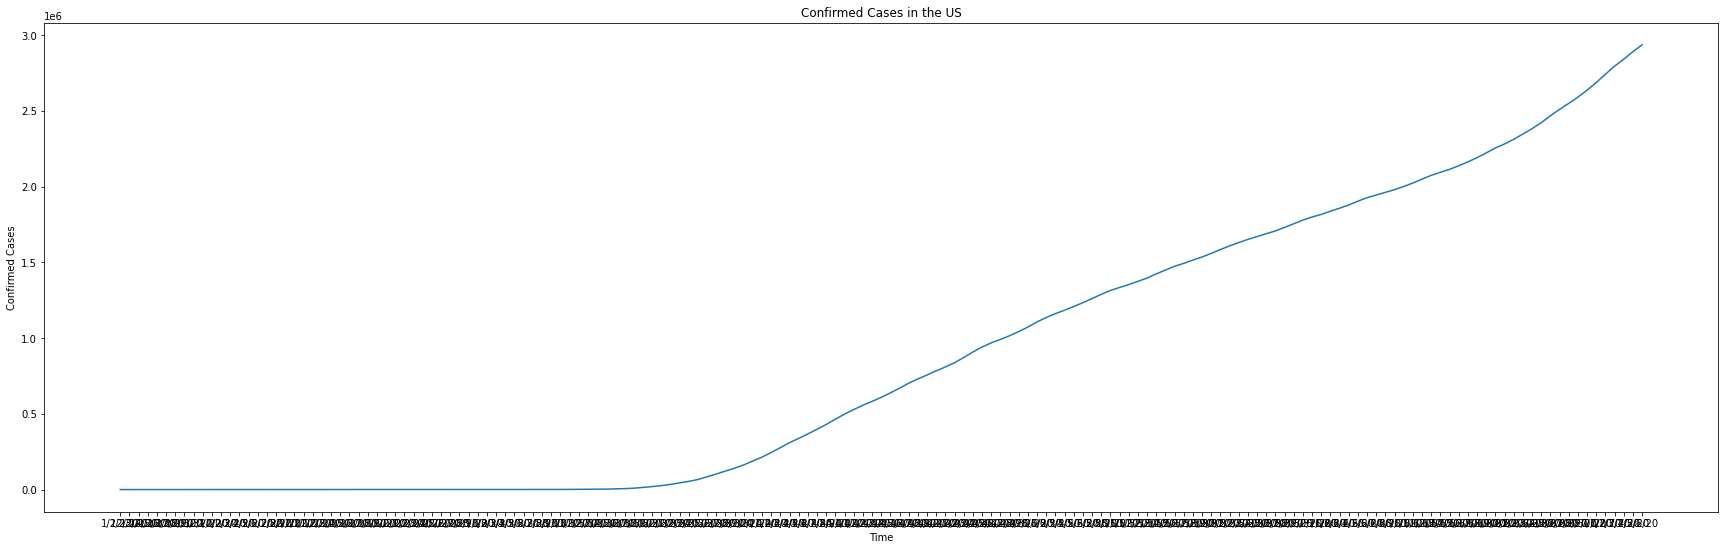

In [10]:
plt.figure(figsize=(30,9))
plt.title("Confirmed Cases in the US")
plt.xlabel("Time")
plt.ylabel("Confirmed Cases")
plt.plot(raw_conf_df.columns[3:], us_conf[3:])

In [11]:
"""fig = go.Figure(data=[
    go.Scatter(
        name="Confirmed Cases",
        x=raw_conf_df.columns[3:],
        y=us_conf[3:]
    ),
    go.Scatter(
        name="Confirmed Deaths",
        x=raw_death_df.columns[3:],
        y=us_deaths[3:]
    ),
    go.Scatter(
        name="Confirmed Recoveries",
        x=raw_rec_df.columns[3:],
        y=us_rec[3:]
    )

])
# fig.update_yaxes(type="log")

fig.show()"""

In [12]:
from statsmodels.tsa.stattools import adfuller

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [13]:
result = adfuller(us_conf[3:].values)

In [14]:
result

(2.476316217372621,
 0.9990418131654889,
 10,
 156,
 {'1%': -3.4729792729247793,
  '10%': -2.5767469641683105,
  '5%': -2.8802520918255534},
 2751.543994471417)

In [15]:
#Non-Stationary

In [16]:
import math
from sklearn.preprocessing import MinMaxScaler
#Preprocess Data
train_size = 0.9
total_data = np.array(us_conf[3:].values).reshape(-1,1)
scaler = MinMaxScaler()
data_norm = scaler.fit_transform(total_data)
#train_data = data_norm[:math.floor(train_size*len(total_data))]

In [17]:
def sliding_window(data, seq_length,out_seq_length):
  x = []
  y = []

  for i in range(len(data)-seq_length-1):
    if ((i+seq_length+out_seq_length)<len(data)):
      _x = data[i:(i+seq_length)]
      _y = data[i+seq_length+out_seq_length]
      x.append(_x)
      y.append(_y)

  return np.array(x), np.array(y)

X, y = sliding_window(data_norm, 30, 14)

#X = X.reshape(122,30)
#y = y.reshape(122)
print(X.shape)
print(y.shape)

(123, 30, 1)
(123, 1)


In [18]:
dataX = Variable(torch.Tensor(np.array(X)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(X[0:math.floor(train_size*123)])))
trainY = Variable(torch.Tensor(np.array(y[0:math.floor(train_size*123)])))

testX = Variable(torch.Tensor(np.array(X[math.floor(train_size*123):len(X)])))
testY = Variable(torch.Tensor(np.array(y[math.floor(train_size*123):len(y)])))
print(testY.size())

torch.Size([13, 1])


In [19]:
"""
class LSTM(nn.Module):
 
    def __init__(self, input_dim, hidden_dim, batch_size, output_dim=1,
                    num_layers=2):
      super(LSTM, self).__init__()
      self.input_dim = input_dim
      self.hidden_dim = hidden_dim
      self.batch_size = batch_size
      self.num_layers = num_layers

      # Define the LSTM layer
      self.lstm = nn.LSTM(self.input_dim, self.hidden_dim, self.num_layers)

      # Define the output layer
      self.linear = nn.Linear(self.hidden_dim, output_dim)

    def init_hidden(self):
      return (torch.zeros(self.num_layers, self.batch_size, self.hidden_dim),
              torch.zeros(self.num_layers, self.batch_size, self.hidden_dim))
      
    def forward(self, input):
      lstm_out, _ = self.lstm((self.input_dim, self.batch_size, -1))
      y_pred = self.linear(lstm_out[-1].view(self.batch_size, -1))
      return y_pred.view(-1)
"""
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        #print(x.view())
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        
        return out

h1 = 128
lstm_input_size = 1
output_dim = 1
num_layers = 1
batch_size = 4
model = LSTM(output_dim, lstm_input_size, h1,num_layers, 30)
print(model)

LSTM(
  (lstm): LSTM(1, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)


In [20]:
loss_fn = torch.nn.MSELoss(size_average=False)
learning_rate = 0.001
optimiser = torch.optim.Adam(model.parameters(), lr=learning_rate)

#####################
# Train model
#####################
num_epochs = 5000
hist = np.zeros(num_epochs)

for t in range(num_epochs):
    # Clear stored gradient
    model.zero_grad()
    
    # Initialise hidden state
    # Don't do this if you want your LSTM to be stateful
    #model.hidden = model.init_hidden()
    
    # Forward pass
    y_pred = model.forward(trainX)
    #print(y_pred)

    loss = loss_fn(y_pred, trainY)
    #print(loss)
    if t % 100 == 0:
        print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    # Zero out gradient, else they will accumulate between epochs
    optimiser.zero_grad()

    # Backward pass
    loss.backward()

    # Update parameters
    optimiser.step()

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning:

size_average and reduce args will be deprecated, please use reduction='sum' instead.



Epoch  0 MSE:  26.388309478759766
Epoch  100 MSE:  0.4958292245864868
Epoch  200 MSE:  0.1733594685792923
Epoch  300 MSE:  0.1899634152650833
Epoch  400 MSE:  0.15368865430355072
Epoch  500 MSE:  0.14075079560279846
Epoch  600 MSE:  0.13065311312675476
Epoch  700 MSE:  0.11518467217683792
Epoch  800 MSE:  0.08898482471704483
Epoch  900 MSE:  0.10098566859960556
Epoch  1000 MSE:  0.06792937964200974
Epoch  1100 MSE:  0.07663581520318985
Epoch  1200 MSE:  0.487183153629303
Epoch  1300 MSE:  0.16917631030082703
Epoch  1400 MSE:  0.14046038687229156
Epoch  1500 MSE:  0.12806007266044617
Epoch  1600 MSE:  0.11612934619188309
Epoch  1700 MSE:  0.09941370040178299
Epoch  1800 MSE:  0.21224744617938995
Epoch  1900 MSE:  0.22735600173473358
Epoch  2000 MSE:  0.13477060198783875
Epoch  2100 MSE:  0.1253061294555664
Epoch  2200 MSE:  0.11732961237430573
Epoch  2300 MSE:  0.10824713110923767
Epoch  2400 MSE:  0.09725934267044067
Epoch  2500 MSE:  0.08364979177713394
Epoch  2600 MSE:  0.06807844340

torch.Size([13, 1])


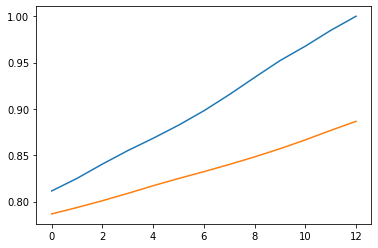

In [23]:
y_pred_test = model(testX)
y_pred_test = y_pred_test.data.numpy()
print(testY.size())
plt.plot(range(13), testY.data.numpy(),label="Real")
plt.plot(range(13),y_pred_test,  label="pred")

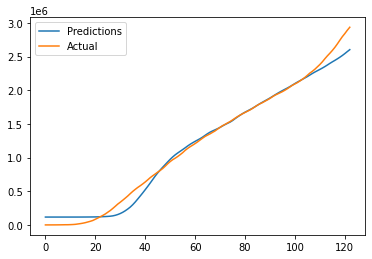

In [24]:
pred_data = model(dataX).data.numpy()
plt.plot(range(dataX.size(0)), scaler.inverse_transform(pred_data), label="Predictions")
plt.plot(range(dataX.size(0)), scaler.inverse_transform(dataY.data.numpy()), label="Actual")
plt.legend()

In [25]:
#Vector Auto Regressive Model
from statsmodels.tsa.api import VAR
from statsmodels.tsa.base.datetools import dates_from_str
dt = {
    "Confirmed" : us_conf[3:],
    "Deaths" : us_deaths[3:],
    "Recovered" : us_rec[3:]
}
df = pd.DataFrame(dt, columns=["Confirmed", "Deaths", "Recovered"])
df.index = pd.DatetimeIndex(dates_from_str(df.index))
df = df.astype("float")
df.head()

,Confirmed,Deaths,Recovered
2020-01-22,1.0,0.0,0.0
2020-01-23,1.0,0.0,0.0
2020-01-24,2.0,0.0,0.0
2020-01-25,2.0,0.0,0.0
2020-01-26,5.0,0.0,0.0


In [26]:
model = VAR(np.array(df))
results = model.fit()

In [27]:
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 07, Jul, 2020
Time:                     19:14:34
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    46.6120
Nobs:                     166.000    HQIC:                   46.4783
Log likelihood:          -4544.75    FPE:                1.39842e+20
AIC:                      46.3870    Det(Omega_mle):     1.30201e+20
--------------------------------------------------------------------
Results for equation y1
           coefficient       std. error           t-stat            prob
------------------------------------------------------------------------
const      2197.804608       504.486241            4.357           0.000
L1.y1         1.125214         0.004500          250.054           0.000
L1.y2        -1.361804         0.061483          -22.149           0.000
L1.y3        -0.148169

In [28]:
!pip freeze > requirements.txt

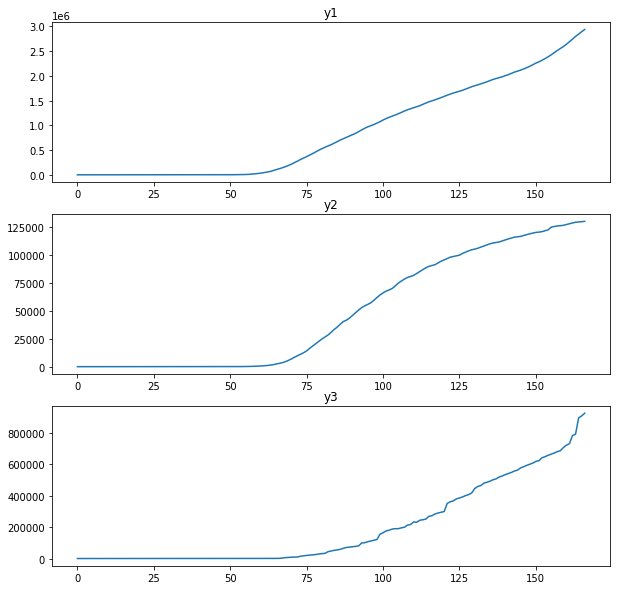

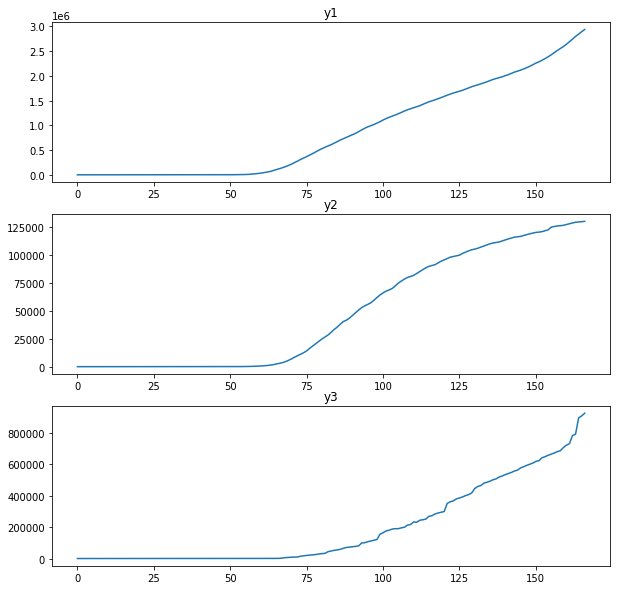

In [29]:
results.plot()

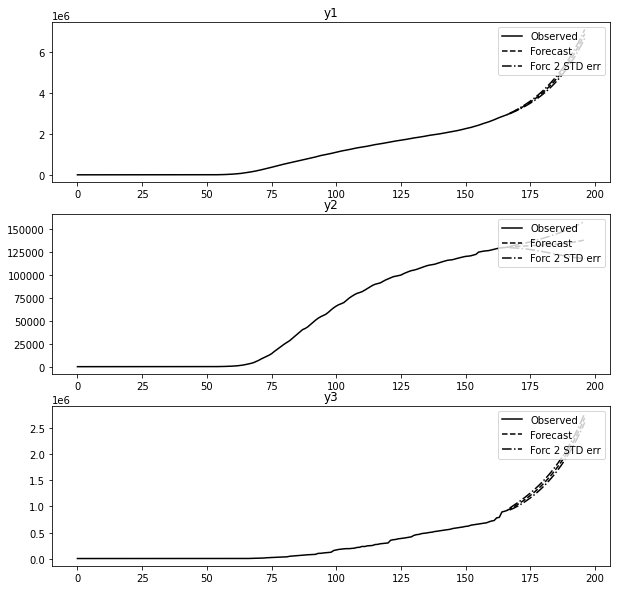

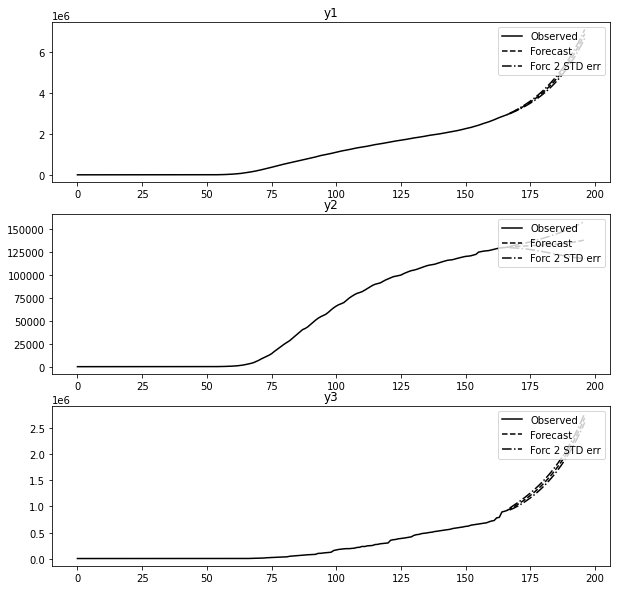

In [30]:
results.plot_forecast(30)